<a href="https://colab.research.google.com/github/SophieHuGit/DeepLearningClothingMatchOnTaobao/blob/master/TransferLearningCNN_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os
import pandas as pd
import seaborn as sns
import zipfile
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
start = dt.datetime.now()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## Use Keras Pretrained Models dataset

In [0]:
zip_ref = zipfile.ZipFile('drive/My Drive/data/Datasets.zip', 'r')
zip_ref.extractall('unzipped_folder') # unzip directory
zip_ref.close()

In [0]:
zip_ref = zipfile.ZipFile('drive/My Drive/data/keras-pretrained-models.zip', 'r')
zip_ref.extractall('keras-pretrained-models') # unzip directory
zip_ref.close()

Copy the pretrained models to the cache directory (~/.keras/models) where keras is looking for them.

In [5]:
!ls keras-pretrained-models/keras-pretrained-models/

imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Kuszma.JPG
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [0]:
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [7]:
!cp keras-pretrained-models/keras-pretrained-models/xception* ~/.keras/models/
!ls ~/.keras/models

xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


## Check the clothing categories

In [0]:
CATEGORIES = ['33', '42', '48', '50', '52', '81', '111', '137', '155', '160',
               '178', '228', '284', '311', '368', '453', '461', '505', '516', '522']
NUM_CATEGORIES = len(CATEGORIES)

In [9]:
data_dir = 'unzipped_folder/Datasets'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

33 2615 images
42 2561 images
48 3364 images
50 2150 images
52 7280 images
81 1605 images
111 4766 images
137 2761 images
155 3054 images
160 2652 images
178 1833 images
228 2953 images
284 5625 images
311 1526 images
368 10234 images
453 1869 images
461 4889 images
505 3499 images
516 2259 images
522 1409 images


In [10]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.head(5)
train.shape

,file,category_id,category
0,train/33/1782241.jpg,0,33
1,train/33/2815594.jpg,0,33
2,train/33/2256906.jpg,0,33
3,train/33/2240892.jpg,0,33
4,train/33/792660.jpg,0,33


(68904, 3)

In [11]:
train = pd.concat([train[train['category'] == c] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
train.head(5)
train.shape

,file,category_id,category
0,train/522/570643.jpg,19,522
1,train/160/1582099.jpg,9,160
2,train/50/2253335.jpg,3,50
3,train/505/1672311.jpg,17,505
4,train/52/721403.jpg,4,52


(68904, 3)

In [12]:
test = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(test_dir, category)):
        test.append(['test/{}/{}'.format(category, file), category_id, category])
test = pd.DataFrame(test, columns=['file', 'category_id', 'category'])
test.head(5)
test.shape

,file,category_id,category
0,test/33/1959936.jpg,0,33
1,test/33/1748635.jpg,0,33
2,test/33/2003467.jpg,0,33
3,test/33/2056506.jpg,0,33
4,test/33/941048.jpg,0,33


(19140, 3)

In [13]:
# Read actual test data category
test = pd.concat([test[test['category'] == c] for c in CATEGORIES])
test = test.sample(frac=1)
test.index = np.arange(len(test))
test.head(5)
test.shape

,file,category_id,category
0,test/33/2677946.jpg,0,33
1,test/368/2819544.jpg,14,368
2,test/284/2890412.jpg,12,284
3,test/505/1223806.jpg,17,505
4,test/368/421107.jpg,14,368


(19140, 3)

In [14]:
# create column file path: `test/xxx.jpg`
# create column file: `xxx.jpg`
test['file2'] = test['file'].str.split('/').str[0]+'/'+test['file'].str.split('/').str[2]
test.drop('file',axis=1,inplace=True)
test.rename(columns={'file2':'filepath'},inplace=True)
test['file'] = test['filepath'].str.split('/').str[1]
test.drop('category_id',axis=1,inplace=True)
test.drop('category',axis=1,inplace=True)
test.head(5)
test.shape

,filepath,file
0,test/2677946.jpg,2677946.jpg
1,test/2819544.jpg,2819544.jpg
2,test/2890412.jpg,2890412.jpg
3,test/1223806.jpg,1223806.jpg
4,test/421107.jpg,421107.jpg


(19140, 2)

In [0]:
# extract image info
#test = []
#for file in os.listdir(test_dir):
#    test.append(['test/{}'.format(file), file])
#test = pd.DataFrame(test, columns=['filepath', 'file'])
#test.head(5)
#test.shape

In [0]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

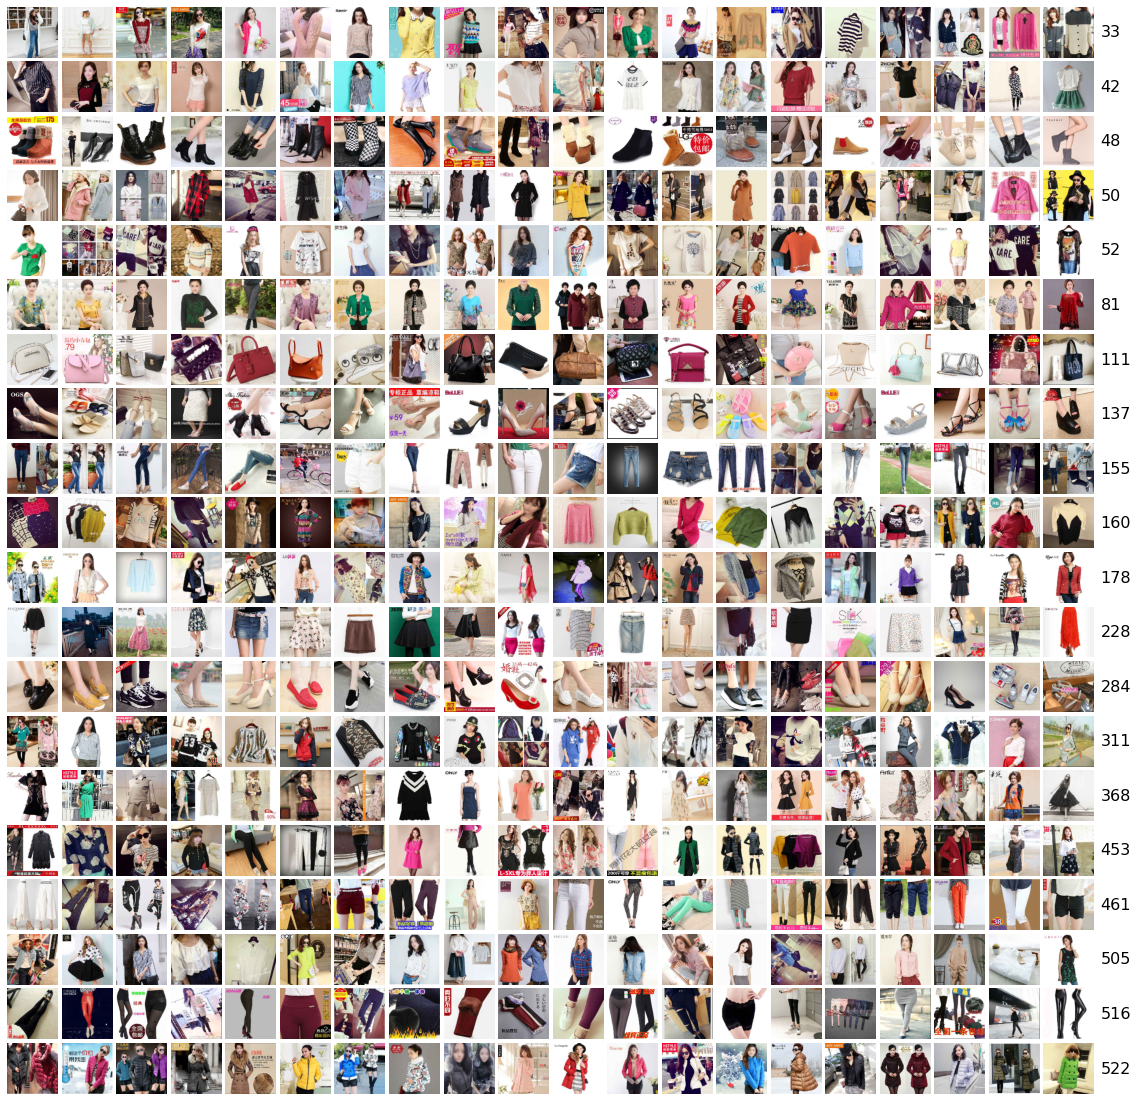

In [17]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

In [18]:
np.random.seed(seed=1987)
rnd = np.random.random(len(train))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values
len(ytr), len(yv)

(55022, 13882)

## Extract Xception bottleneck feature

In [19]:
INPUT_SIZE = 80
POOLING = 'avg'
x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in tqdm(enumerate(train['file'])):
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

68904it [01:54, 600.49it/s]

Train Images shape: (68904, 80, 80, 3) size: 1,322,956,800


In [20]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((55022, 80, 80, 3), (13882, 80, 80, 3), (55022,), (13882,))
13882/13882 [==============================] - 73s 5ms/step
Xception train bottleneck features shape: (55022, 2048) size: 112,685,056
Xception valid bottleneck features shape: (13882, 2048) size: 28,430,336


## LogReg on Xception bottleneck features

In [22]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=1987)
logreg.fit(train_x_bf, ytr)
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1987, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
print('Validation Xception Accuracy {}'.format(accuracy_score(yv, valid_preds)))

Validation Xception Accuracy 0.40541708687509004


## Confusion matrix of validation

In [0]:
cnf_matrix = confusion_matrix(yv, valid_preds)

In [0]:
#explicit_category = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
#pd.DataFrame({'class': CATEGORIES, 'abbreviation': explicit_category})

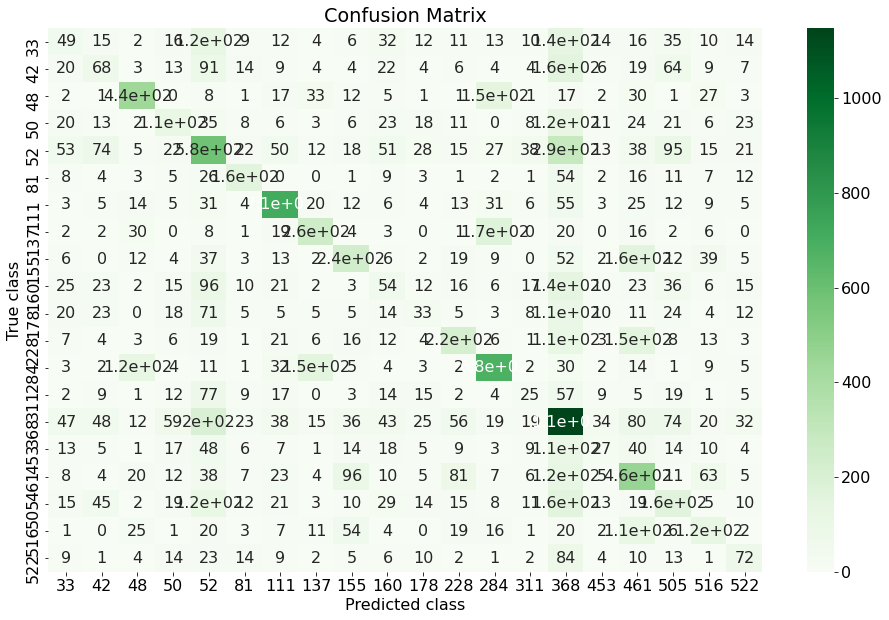

In [26]:
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(CATEGORIES)
ax.set_yticklabels(CATEGORIES)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show();

## Confusion matrix of test set

In [29]:
test_x_bf = xception_bottleneck.predict(x_test, batch_size=32, verbose=1)
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))
test_preds = logreg.predict(test_x_bf)

19140/19140 [==============================] - 109s 6ms/step
Xception test bottleneck features shape: (19140, 2048) size: 39,198,720


In [0]:
test['category_id'] = test_preds
test['category'] = [CATEGORIES[c] for c in test_preds]
test[['file', 'category']].to_csv('submission.csv', index=False)

In [0]:
# confusion matrix
#cnf_matrix = confusion_matrix(yv, test_preds)